In [53]:
from __future__ import print_function

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
import seaborn as sns
from ipywidgets import fixed, interact, interact_manual, interactive
from natsort import index_natsorted
from scipy.stats import norm

%load_ext line_profiler
%matplotlib inline
pyo.init_notebook_mode(connected=True)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [54]:
# sulIntro = 1936

In [55]:
df = pd.read_csv("../data/3_analysis-resistance/all_rgiout_2022-12-01", sep="\t")
df = df.sort_values(
    by=["Accession_Number"],
    ascending=True,
    key=lambda x: np.argsort(index_natsorted(df["Accession_Number"])),
    ignore_index=True,
)
df[["Species", "Subspecies"]] = df["Strain"].str.split("subsp.", 1, expand=True)
df = df.replace(np.nan, "Null", regex=True)

rgiintegron = pd.read_csv(
    "../data/3_analysis-resistance/rgi_subset_integronoverlap",
    sep="\t",
    names=df.columns.values,
)
rgiintegron["Species"] = rgiintegron["Strain"].str.split("subsp.", 1, expand=True)
rgiintegron["Subspecies"] = "Null"
contigdf = pd.concat(
    [
        df["Accession_Number"],
        df["Contig"].str.split("_", expand=True)[0].str.split("|").str[-1],
    ],
    axis=1,
).copy()

ecoli_mlplasmid_out = pd.read_csv(
    "../data/3_analysis-plasmid/merged-Escherichia_coli-mlplasmidout", sep="\t"
)
ecoli_mlplasmid_out["Contig"] = ecoli_mlplasmid_out["Contig_name"].str.split(
    " ", expand=True
)[0]
ecoliplasmids_df = contigdf.loc[
    contigdf["Accession_Number"].isin(ecoli_mlplasmid_out["AccNum"])
]
ecoliplasmids_df = ecoliplasmids_df.loc[
    ecoliplasmids_df[0].isin(ecoli_mlplasmid_out["Contig"])
]
ecoliplasmids_df = df.loc[ecoliplasmids_df.index].copy()

In [56]:
# sul_resist = df.loc[df["Drug Class"].str.contains("sulfonamide")]
# sul_resist = df.loc[df["Best_Hit_ARO"].str.contains("sul")]

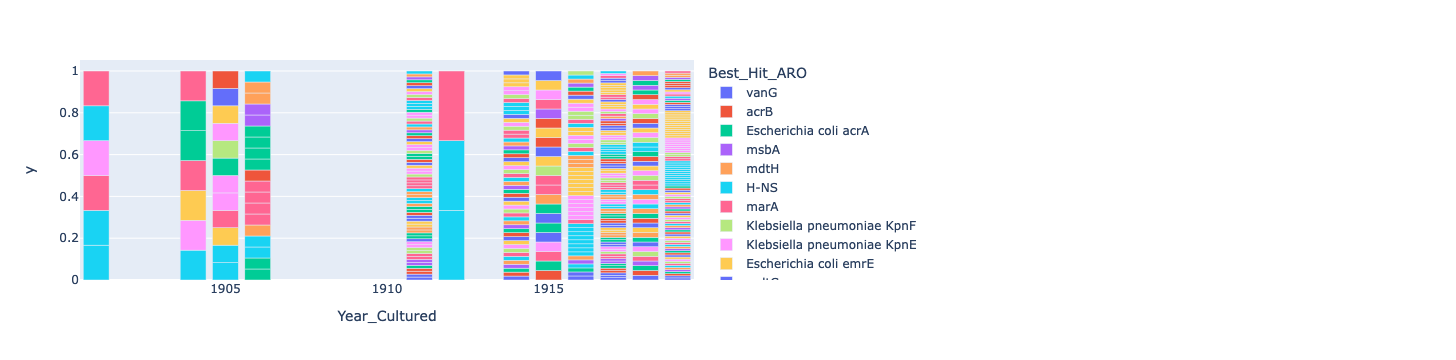

In [57]:
px.bar(
    df.loc[df["Year_Cultured"] < 1920],
    x="Year_Cultured",
    y=df.loc[df["Year_Cultured"] < 1920]["Year_Cultured"].map(
        (
            1 / df.loc[df["Year_Cultured"] < 1920]["Year_Cultured"].value_counts()
        ).to_dict()
    ),
    hover_data=[
        "Accession_Number",
        "Resistance Mechanism",
        "Best_Hit_ARO",
        "Drug Class",
        "AMR Gene Family",
        "Strain",
    ],
    color="Best_Hit_ARO",
)

# ESKAPE

In [61]:
eskape_pathogens = df.loc[
    df["Strain"].str.contains(
        "Enterococcus faecium|Salmonella enterica|Klebsiella pneumoniae|Acinetobacter baumannii|Pseudomonas aeruginosa|Enterobacter"
    )
].copy()
eskape_pathogens["CleanSpecies"] = eskape_pathogens["Strain"]
eskape_pathogens.loc[
    eskape_pathogens["Strain"].str.contains("Enterococcous faecium"), ["CleanSpecies"]
] = "Enterococcus faecium"
eskape_pathogens.loc[
    eskape_pathogens["Strain"].str.contains("Salmonella enterica"), ["CleanSpecies"]
] = "Salmonella enterica"
eskape_pathogens.loc[
    eskape_pathogens["Strain"].str.contains("Klebsiella pneumoniae"), ["CleanSpecies"]
] = "Klebsiella pneumoniae"
eskape_pathogens.loc[
    eskape_pathogens["Strain"].str.contains("Acinetobacter baumannii"), ["CleanSpecies"]
] = "Acinetobacter baumannii"
eskape_pathogens.loc[
    eskape_pathogens["Strain"].str.contains("Pseudomonas aeruginosa"), ["CleanSpecies"]
] = "Pseudomonas aeruginosa"
eskape_pathogens.loc[
    eskape_pathogens["Strain"].str.contains("Enterobacter"), ["CleanSpecies"]
] = "Enterobacter sp."
eskape_pathogens.drop_duplicates("Accession_Number").sort_values("Year_Cultured")
family_name = eskape_pathogens['CleanSpecies'].str.split(' ', expand=True)[0].str[0]
species_name = eskape_pathogens['CleanSpecies'].str.split(' ', expand=True)[1]
eskape_pathogens['Species'] = family_name + ". " + species_name
eskape_pathogens.loc[eskape_pathogens['Species'].str.match('E. sp.'), ['Species']] = 'Enterobacter sp.'

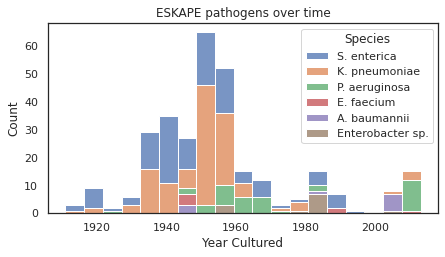

In [114]:
sns.set_theme(font="Arial", style="white")
sns.set_palette("deep")
histogram = sns.histplot(
    data=eskape_pathogens.drop_duplicates("Accession_Number"),
    x="Year_Cultured",
    hue="Species",
    multiple="stack",
    # hue_order=topx,
    legend="full",
)
histogram.set(xlabel="Year Cultured", title="ESKAPE pathogens over time")
legend = histogram.get_legend()
handles = legend.legendHandles
# legend.remove()

# specie_counts = genomeandyear_nctcdf['Specie_Name'].value_counts()
# histogram.legend(handles, topx, title="Species")
# histogram._legend.set_title('Species')
figure = plt.gcf()  # get current figure
figure.set_size_inches(7, 3.5)
plt.savefig('./figs/eskape-year_cultured-hist.png', dpi=300, bbox_inches='tight', transparent=False)

In [108]:
drugyear_usage = {
    "fluoroquinolone antibiotic": 1962,
    "penam": 1943,
    # "cephalosporin": 1964,
    "tetracycline antibiotic": 1948,
    # "phenicol antibiotic": 1949,
    "macrolide antibiotic": 1952,
    "rifamycin antibiotic": 1963,
    "aminoglycoside antibiotic": 1946,
    # "peptide antibiotic": 1941,  # not sure about this one
    # "glycylcycline": 1948,  # using year tetracyclines were introduced clinically
    # "triclosan": 1968,  # using wiki page
    # "cephamycin": 1964,  # using cephalosporin year
    # "carbapenem": 1985,
    # "aminocoumarin antibiotic": 1965,  # best guess from wiki article
    # "penem": 1985,  # using year carbapenems were introduced
    # "monobactam": 1986,
    # "disinfecting agents and intercalating dyes": 1930,  # no clue
    # "acridine dye": 1970,  # no clue?
    "diaminopyrimidine antibiotic": 1962,
    # "elfamycin antibiotic": 1978,  # no clue
    # "fosfomycin": 1971,
    # "nucleoside antibiotic": 2014,  # no clue, but looks newish
    # "lincosamide antibiotic": 1963,
    "nitroimidazole antibiotic": 1960,
    # "Null": 1920,
    # "benzalkonium chloride": 1950,  # no clude
    # "rhodamine": 1950,  # no clude
    "sulfonamide antibiotic": 1936,
    # "nitrofuran antibiotic": 1953,
    # "streptogramin antibiotic": 1965,
    # "oxazolidinone antibiotic": 2000,
    "glycopeptide antibiotic": 1958,
    # "fusidic acid": 1962,
    # "pleuromutilin antibiotic": 2007,
    # "bicyclomycin": 1972,  # from wiki
    # "antibacterial free fatty acids": 2000,  # noclude
    # "para-aminosalicylic acid": 1943,
    # "isoniazid": 1952,
    # "polyamine antibiotic": 2005,  # no idea
}

In [109]:
x = {}
frac_resist = {}
count_resist = {}
index = []
# g = pd.DataFrame(columns=eskape_pathogens['CleanSpecies'].drop_duplicates())
for d in drugyear_usage:
    # print(f"{d}\t{drugyear_usage[d]}")
    x[d] = []
    x[d].append(eskape_pathogens.loc[
        (eskape_pathogens["Drug Class"].str.contains(d))
        & (eskape_pathogens["Year_Cultured"] < drugyear_usage[d])
    ])
    x[d].append(eskape_pathogens.loc[
        eskape_pathogens['Year_Cultured'] < drugyear_usage[d]
    ])
    index.append(d.capitalize())
    # print(d)
    for j in ['E. faecium', 'S. enterica', 'K. pneumoniae', 'A. baumannii', 'P. aeruginosa', 'Enterobacter sp.']:
        if j not in frac_resist:
            frac_resist[j] = []
            count_resist[j] = []
        try:
            vc_res_isolates = x[d][0].drop_duplicates('Accession_Number')['Species'].value_counts()[j]
        except:
            vc_res_isolates = 0
        try:
            vc_all_isolates = x[d][1].drop_duplicates('Accession_Number')['Species'].value_counts()[j]
        except:
            vc_all_isolates = 1
        # print(f"{j}\t{vc_res_isolates/vc_all_isolates}\t{vc_res_isolates}\t{vc_all_isolates}")
        frac_resist[j].append(vc_res_isolates/vc_all_isolates)
        count_resist[j].append(vc_res_isolates)
        # print(vc_res_isolates/vc_all_isolates)
fracresist_df = pd.DataFrame(data=frac_resist, index=index)
countresist_df = pd.DataFrame(data=count_resist, index=index)
fracresist_df

,E. faecium,S. enterica,K. pneumoniae,A. baumannii,P. aeruginosa,Enterobacter sp.
Fluoroquinolone antibiotic,1.0,0.969072,0.946429,1.000000,1.0,0.666667
Penam,0.0,0.956522,0.818182,0.000000,1.0,0.000000
Tetracycline antibiotic,0.0,0.948276,0.833333,1.000000,1.0,0.000000
Macrolide antibiotic,1.0,0.955882,0.857143,1.000000,1.0,0.000000
Rifamycin antibiotic,1.0,0.969388,0.947368,0.666667,1.0,0.666667
Aminoglycoside antibiotic,0.0,0.960784,0.818182,0.000000,1.0,0.000000
Diaminopyrimidine antibiotic,0.0,0.938144,0.946429,1.000000,1.0,0.666667
Nitroimidazole antibiotic,0.0,0.895833,0.871560,0.000000,0.0,0.666667
Sulfonamide antibiotic,0.0,0.000000,0.055556,0.000000,1.0,0.000000
Glycopeptide antibiotic,1.0,0.869565,0.831776,0.000000,1.0,0.500000


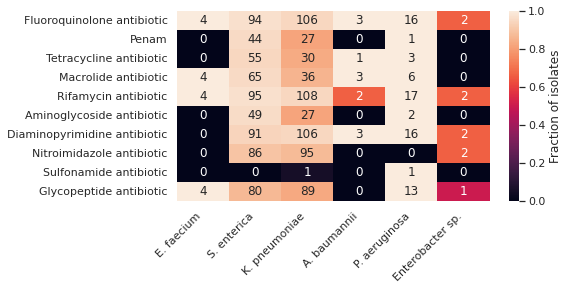

In [110]:
sns.heatmap(fracresist_df, annot=countresist_df, fmt=".0f", cbar_kws={'label': 'Fraction of isolates'})
figure = plt.gcf()  # get current figure
figure.set_size_inches(7, 3.5)
plt.xticks(rotation=45, ha='right')
plt.savefig('./figs/eskape-heatmap_preab-resist.png', dpi=300, bbox_inches='tight', transparent=False)

In [111]:
eskape_pathogens['Resistance Mechanism'].value_counts()

antibiotic efflux                                                                      6007
antibiotic target alteration                                                           1985
antibiotic target alteration; antibiotic efflux                                         670
antibiotic inactivation                                                                 632
antibiotic efflux; reduced permeability to antibiotic                                   309
reduced permeability to antibiotic                                                      209
antibiotic target alteration; antibiotic efflux; reduced permeability to antibiotic     119
antibiotic target replacement                                                            44
Null                                                                                     31
antibiotic target protection                                                             10
Name: Resistance Mechanism, dtype: int64

In [112]:
eskape_noefflux = eskape_pathogens.loc[eskape_pathogens['Resistance Mechanism'] != 'antibiotic efflux'].copy()
x = {}
frac_resist = {}
count_resist = {}
index = []
# g = pd.DataFrame(columns=eskape_pathogens['CleanSpecies'].drop_duplicates())
for d in drugyear_usage:
    # print(f"{d}\t{drugyear_usage[d]}")
    x[d] = []
    x[d].append(eskape_noefflux.loc[
        (eskape_noefflux["Drug Class"].str.contains(d))
        & (eskape_noefflux["Year_Cultured"] < drugyear_usage[d])
    ])
    x[d].append(eskape_noefflux.loc[
        eskape_noefflux['Year_Cultured'] < drugyear_usage[d]
    ])
    index.append(d.capitalize())
    # print(d)
    for j in ['E. faecium', 'S. enterica', 'K. pneumoniae', 'A. baumannii', 'P. aeruginosa', 'Enterobacter sp.']:
        if j not in frac_resist:
            frac_resist[j] = []
            count_resist[j] = []
        try:
            vc_res_isolates = x[d][0].drop_duplicates('Accession_Number')['Species'].value_counts()[j]
        except:
            vc_res_isolates = 0
        try:
            vc_all_isolates = x[d][1].drop_duplicates('Accession_Number')['Species'].value_counts()[j]
        except:
            vc_all_isolates = 1
        # print(f"{j}\t{vc_res_isolates/vc_all_isolates}\t{vc_res_isolates}\t{vc_all_isolates}")
        frac_resist[j].append(vc_res_isolates/vc_all_isolates)
        count_resist[j].append(vc_res_isolates)
        # print(vc_res_isolates/vc_all_isolates)
fracresist_df = pd.DataFrame(data=frac_resist, index=index)
countresist_df = pd.DataFrame(data=count_resist, index=index)
fracresist_df

,E. faecium,S. enterica,K. pneumoniae,A. baumannii,P. aeruginosa,Enterobacter sp.
Fluoroquinolone antibiotic,0.0,0.969072,0.910714,0.666667,1.0,0.666667
Penam,0.0,0.956522,0.818182,0.000000,1.0,0.000000
Tetracycline antibiotic,0.0,0.948276,0.777778,0.000000,1.0,0.000000
Macrolide antibiotic,0.0,0.000000,0.000000,0.000000,1.0,0.000000
Rifamycin antibiotic,0.0,0.969388,0.903509,0.000000,1.0,0.666667
Aminoglycoside antibiotic,0.0,0.882353,0.000000,0.000000,1.0,0.000000
Diaminopyrimidine antibiotic,0.0,0.000000,0.000000,0.000000,1.0,0.000000
Nitroimidazole antibiotic,0.0,0.000000,0.000000,0.000000,0.0,0.000000
Sulfonamide antibiotic,0.0,0.000000,0.055556,0.000000,1.0,0.000000
Glycopeptide antibiotic,1.0,0.869565,0.831776,0.000000,1.0,0.500000


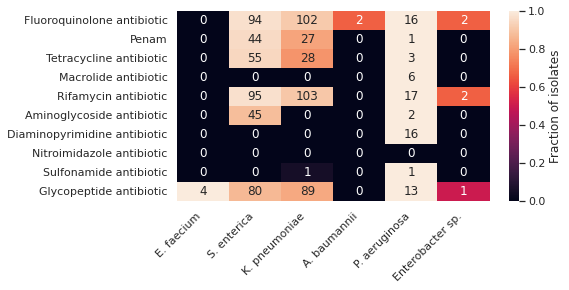

In [113]:
sns.heatmap(fracresist_df, annot=countresist_df, fmt=".0f", cbar_kws={'label': 'Fraction of isolates'})
figure = plt.gcf()  # get current figure
figure.set_size_inches(7, 3.5)
plt.xticks(rotation=45, ha='right')
plt.savefig('./figs/eskape-heatmap_preab-resist_noefflux.png', dpi=300, bbox_inches='tight', transparent=False)

In [6]:
df.loc[df["Year_Cultured"] < 1935].value_counts(
    ["Accession_Number", "Species", "Year_Cultured"]
)

Accession_Number  Species                         Year_Cultured
NCTC8457          Vibrio cholerae biotype el tor  1930             102
NCTC9433          Pseudomonas aeruginosa          1925              58
NCTC4169          Escherichia coli                1931              56
NCTC4450          Escherichia coli                1932              54
NCTC2966          Shigella dysenteriae            1929              54
                                                                  ... 
NCTC11212         Chryseobacterium balustinum     1929               1
NCTC8182          Streptococcus agalactiae        1932               1
NCTC8183          Streptococcus agalactiae        1932               1
NCTC8185          Streptococcus agalactiae        1932               1
NCTC1937          Comamonas terrigena             1923               1
Length: 194, dtype: int64

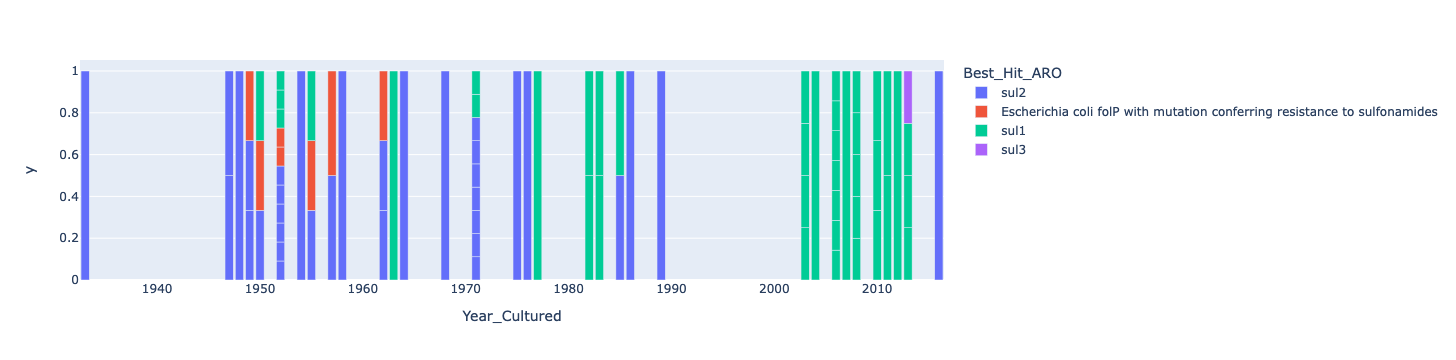

In [7]:
px.bar(
    sul_resist,
    x="Year_Cultured",
    y=sul_resist["Year_Cultured"].map(
        (1 / sul_resist["Year_Cultured"].value_counts()).to_dict()
    ),
    hover_data=[
        "Accession_Number",
        "Resistance Mechanism",
        "Best_Hit_ARO",
        "Drug Class",
        "AMR Gene Family",
        "Strain",
    ],
    color="Best_Hit_ARO",
)

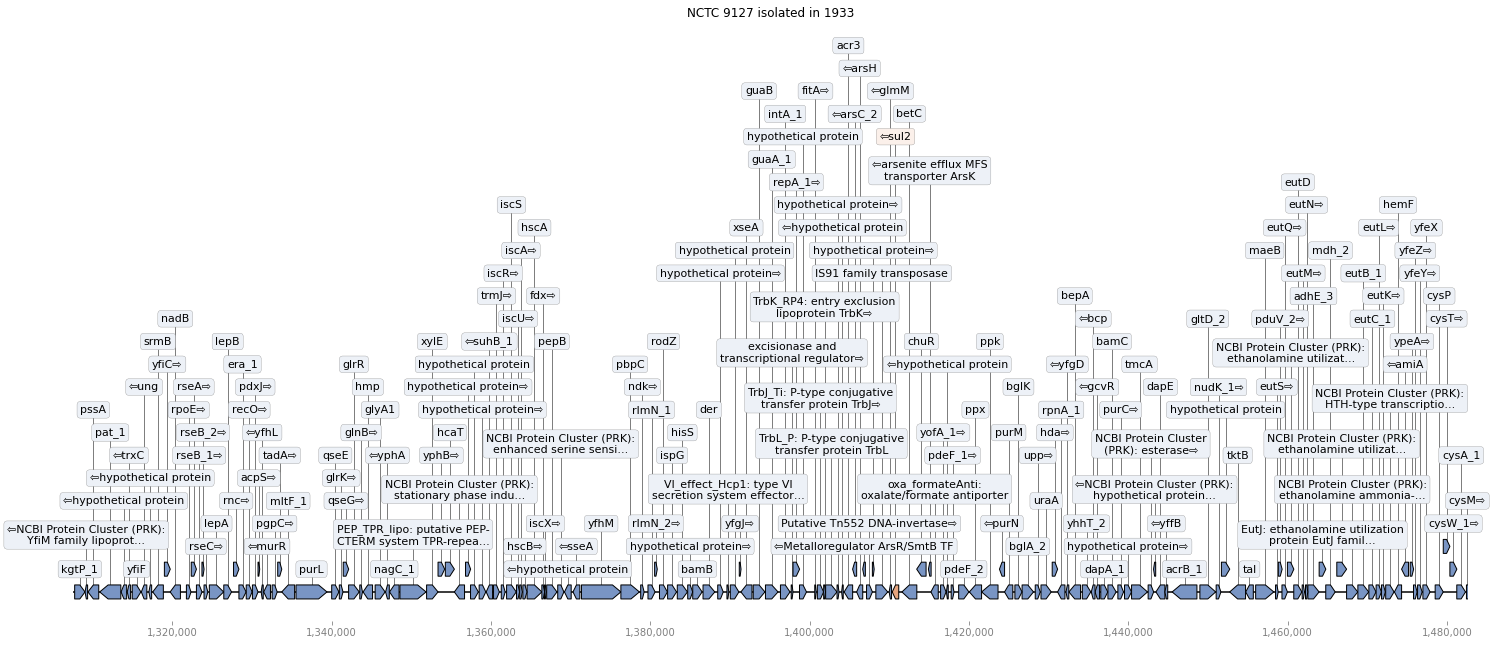

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from Bio import SeqIO
from dna_features_viewer import BiopythonTranslator


class MyCustomTranslator(BiopythonTranslator):
    def compute_feature_color(self, feature):
        if "gene" in feature.qualifiers and feature.qualifiers["gene"] == ["folP_2"]:
            return "#E6A47D"

        if feature.type == "CDS":
            return "#7995C4"

        elif feature.type == "repeat_region":
            return sns.color_palette("deep")[1]
        elif feature.type == "mobile_element":
            return sns.color_palette("deep")[3]
        else:
            return sns.color_palette("deep")[2]

    def compute_feature_label(self, feature):
        if feature.type == "restriction_site":
            return None
        if "gene" in feature.qualifiers:
            if feature.qualifiers["gene"] == ["glmM_2"]:
                return "glmM"
            elif feature.qualifiers["gene"] == ["bin3"]:
                return "Putative Tn552 DNA-invertase"
            elif feature.qualifiers["gene"] == ["folP_2"]:
                return "sul2"
            elif feature.qualifiers["gene"] == ["arsH_1"]:
                return "arsH"
            elif feature.qualifiers["gene"] == ["chuR_2"]:
                return "chuR"
        else:
            prodName = feature.qualifiers["product"][0]
            # print(prodName)
            if "NCBIFAM" in prodName:
                NewprodName = prodName.split(": ")[1]
                if "metalloregulator" in NewprodName:
                    return "Metalloregulator ArsR/SmtB TF"
                return NewprodName

            # print(feature.qualifiers)
        return BiopythonTranslator.compute_feature_label(self, feature)

    def compute_filtered_features(self, features):
        null_list = ["source", "gene"]
        passing = []
        for feature in features:
            if feature.type in null_list:
                continue
            else:
                passing.append(feature)
        return passing


record_dict = SeqIO.to_dict(
    SeqIO.parse(
        "/n/data1/hms/dbmi/baym/arya/projects/project_microtrawler/data/2_analyze-seqs/NCTC/ena/NCTC9127/assembly/assembly_prokka/assembly_prokka.gbk",
        "genbank",
    )
)
# sub_record = record_dict['UGNE01000001.1'][1405899:1417399]
record = record_dict["UGNE01000001.1"]
# 1410370..1411185
graphic_record = MyCustomTranslator().translate_record(record)
# cgraphic_record = graphic_record.crop((1410370 - 30000, 1411185 + 30000))
cgraphic_record = graphic_record.crop((1307573, 1482690))
ax, _ = cgraphic_record.plot(
    figure_width=25, with_ruler=True, strand_in_label_threshold=7
)
plt.title("NCTC 9127 isolated in 1933")
ax.figure.savefig("NCTC9127-sul2-neigh.png", bbox_inches="tight", dpi=200)

In [9]:
df.loc[df["Accession_Number"] == "NCTC418"][
    ["Assembly_No", "Start", "Stop", "Best_Hit_ARO", "Drug Class"]
]

,Assembly_No,Start,Stop,Best_Hit_ARO,Drug Class
466,4,Null,Null,Null,Null
467,2,299166.0,300149.0,PmrF,peptide antibiotic
468,2,303030.0,304685.0,ArnT,peptide antibiotic
469,2,413483.0,414115.0,CRP,macrolide antibiotic; fluoroquinolone antibiot...
470,2,844285.0,844698.0,CrcB,aminoglycoside antibiotic
471,2,1150612.0,1150797.0,rsmA,fluoroquinolone antibiotic; diaminopyrimidine ...
472,2,1158656.0,1160194.0,Klebsiella pneumoniae KpnH,macrolide antibiotic; fluoroquinolone antibiot...
473,2,1160210.0,1161382.0,Klebsiella pneumoniae KpnG,macrolide antibiotic; fluoroquinolone antibiot...
474,2,1161508.0,1162038.0,emrR,fluoroquinolone antibiotic
475,2,1202075.0,1205227.0,oqxB,fluoroquinolone antibiotic; glycylcycline; tet...


{'ENA_LR134213_LR134213': SeqRecord(seq=Seq('ATGTGGATCCGCCCATTGCAGGCGGAACTGAGCGATAACACGCTGGCACTGTAT...AGC'), id='ENA_LR134213_LR134213', name='ENA_LR134213_LR134213', description='Genus species strain strain', dbxrefs=[])}


Text(0.5, 1.0, 'NCTC 418 putative ICE')

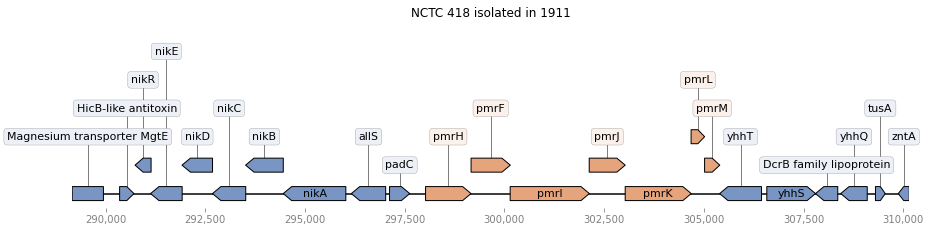

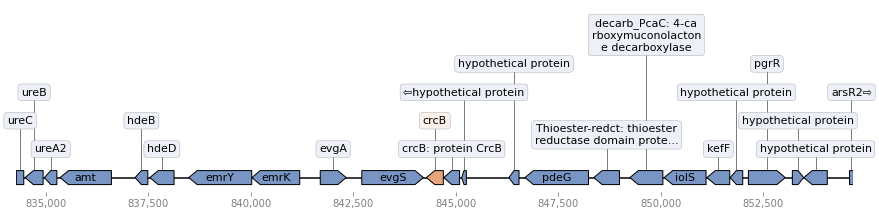

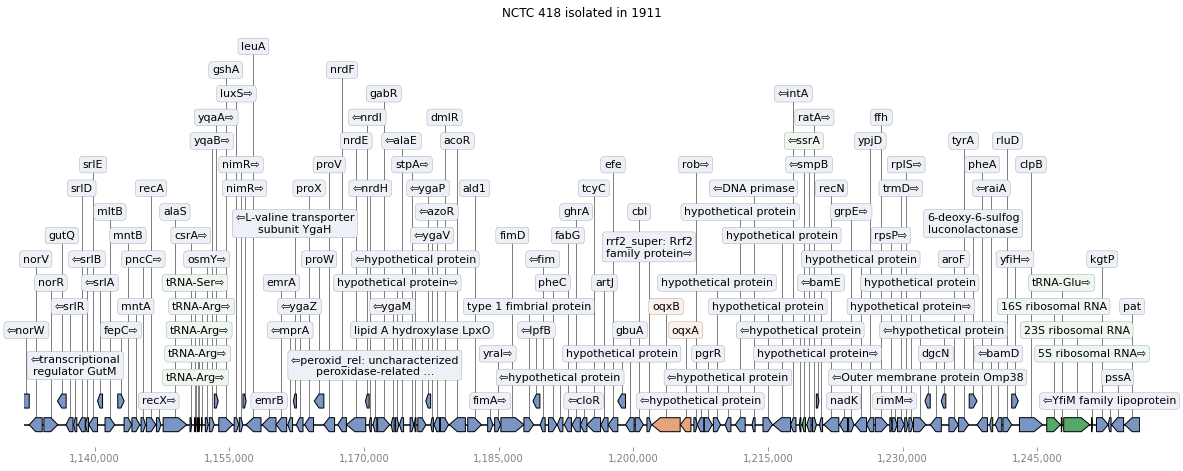

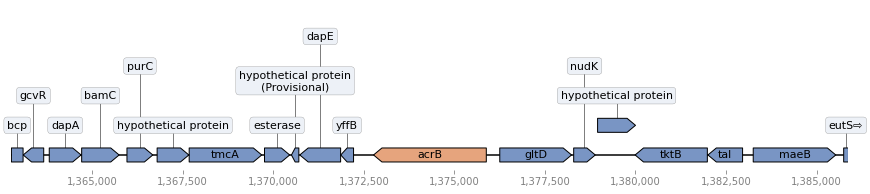

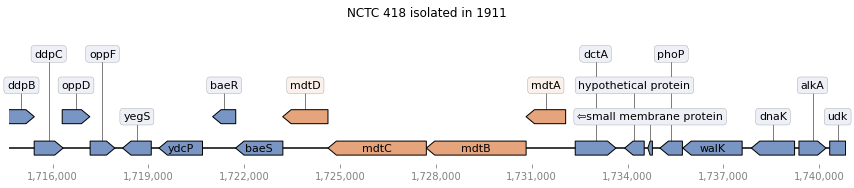

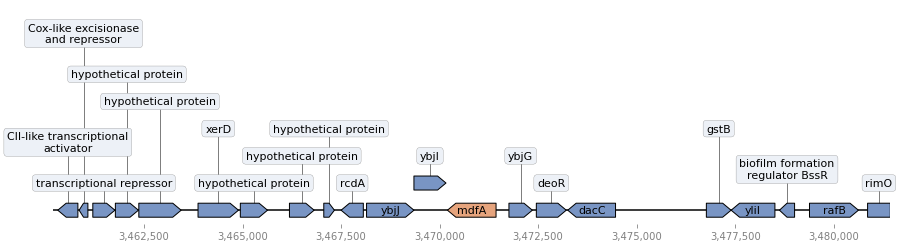

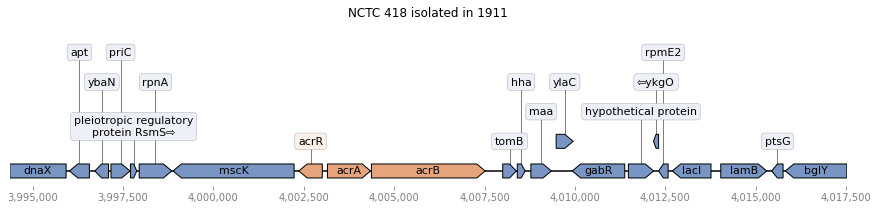

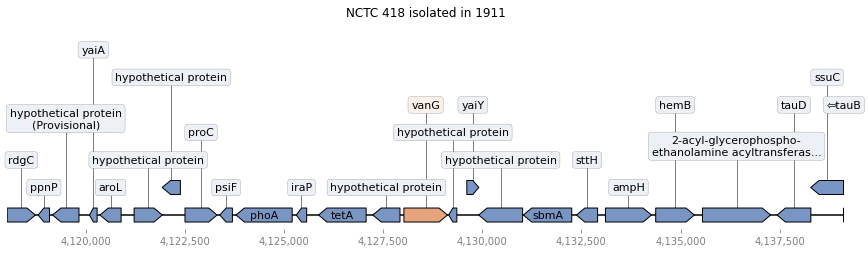

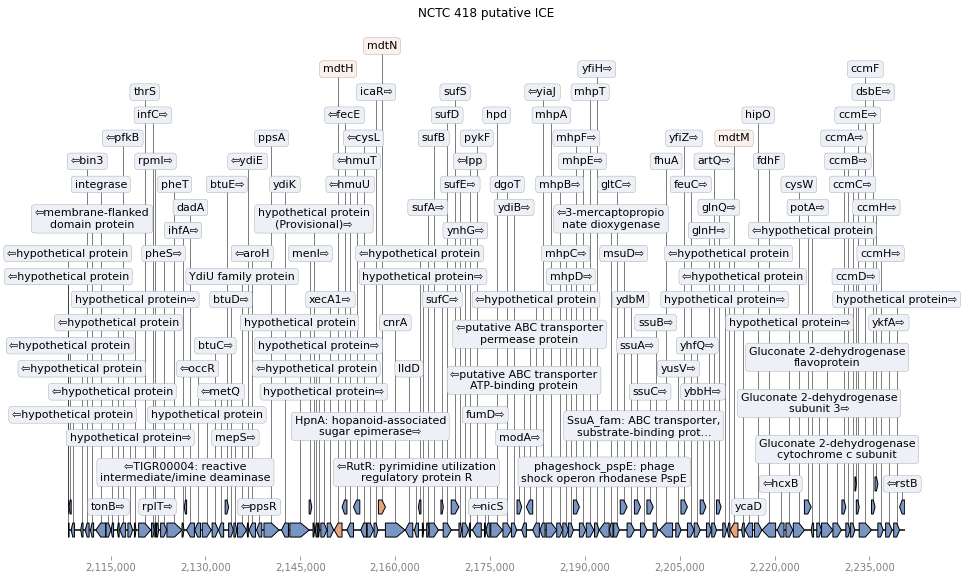

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from Bio import SeqIO
from dna_features_viewer import BiopythonTranslator


class MyCustomTranslator(BiopythonTranslator):
    def compute_feature_color(self, feature):
        pmrF_op = {
            "arnB": "pmrH",
            "arnC": "pmrF",
            "arnA": "pmrI",
            "arnD": "pmrJ",
            "arnT": "pmrK",
            "arnE": "pmrL",
            "arnF": "pmrM",
        }
        oqx_op = {"bepE_1": "oqxB", "bepF": "oqxA"}
        if "gene" in feature.qualifiers:
            if (
                feature.qualifiers["gene"][0] in pmrF_op
                or feature.qualifiers["gene"][0] in oqx_op
                or "crcB" in feature.qualifiers["gene"][0]
                or "mdt" in feature.qualifiers["gene"][0]
                or "mdfA" in feature.qualifiers["gene"][0]
                or "acr" in feature.qualifiers["gene"][0]
                or "ddlA" in feature.qualifiers["gene"][0]
            ):
                return "#E6A47D"
        if feature.type == "CDS":
            return "#7995C4"
        elif feature.type == "repeat_region":
            return sns.color_palette("deep")[1]
        elif feature.type == "mobile_element":
            return sns.color_palette("deep")[3]
        else:
            return sns.color_palette("deep")[2]

    def compute_feature_label(self, feature):
        pmrF_op = {
            "arnB": "pmrH",
            "arnC": "pmrF",
            "arnA": "pmrI",
            "arnD": "pmrJ",
            "arnT": "pmrK",
            "arnE": "pmrL",
            "arnF": "pmrM",
        }
        oqx_op = {"bepE_1": "oqxB", "bepF": "oqxA"}
        if feature.type == "restriction_site":
            return None
        if "gene" in feature.qualifiers:
            if feature.qualifiers["gene"][0] in pmrF_op:
                return pmrF_op[feature.qualifiers["gene"][0]]
            if feature.qualifiers["gene"][0] in oqx_op:
                return oqx_op[feature.qualifiers["gene"][0]]
            if feature.qualifiers["gene"][0] == "ddlA":
                return "vanG"
            if "_" in feature.qualifiers["gene"][0]:
                return feature.qualifiers["gene"][0].split("_")[0]
        else:
            prodName = feature.qualifiers["product"][0]
            # print(prodName)
            if "NCBIFAM" in prodName or "NCBI Protein Cluster" in prodName:
                NewprodName = prodName.split(": ")[1]
                # if 'metalloregulator' in NewprodName:
                #     return 'Metalloregulator ArsR/SmtB TF'
                return NewprodName

            # print(feature.qualifiers)
        return BiopythonTranslator.compute_feature_label(self, feature)

    def compute_filtered_features(self, features):
        null_list = ["source", "gene"]
        passing = []
        for feature in features:
            if feature.type in null_list:
                continue
            else:
                passing.append(feature)
        return passing


record_dict = SeqIO.to_dict(
    SeqIO.parse(
        "/n/data1/hms/dbmi/baym/arya/projects/project_microtrawler/data/2_analyze-seqs/NCTC/ena/NCTC418/assembly_1/assembly_1_prokka/assembly_1_prokka.gbk2",
        "genbank",
    )
)
print(record_dict)
# sub_record = record_dict['UGNE01000001.1'][1405899:1417399]
record = record_dict["ENA_LR134213_LR134213"]
# 1410370..1411185
# 299166.0 	300149.0
graphic_record = MyCustomTranslator().translate_record(record)
cgraphic_record = graphic_record.crop((299166 - 10000, 300149 + 10000))
ax, _ = cgraphic_record.plot(
    figure_width=15, with_ruler=True, strand_in_label_threshold=7
)
plt.title("NCTC 418 isolated in 1911")
ax.figure.savefig("NCTC418-pmrF-neigh.png", bbox_inches="tight", dpi=200)

# 844285.0 	844698.0
# emrKY operon MDR pump controlled by evgAS signaling protein
# also upstream of crcB?? gene
cgraphic_record = graphic_record.crop((844285 - 10000, 844698 + 10000))
ax, _ = cgraphic_record.plot(
    figure_width=15, with_ruler=True, strand_in_label_threshold=7
)


# 1202075.0 	1205227.0
# oqx
cgraphic_record = graphic_record.crop((1202075 - 70000, 1206426 + 50000))
ax, _ = cgraphic_record.plot(
    figure_width=20, with_ruler=True, strand_in_label_threshold=7
)
plt.title("NCTC 418 isolated in 1911")
ax.figure.savefig("NCTC418-oqx-neigh.png", bbox_inches="tight", dpi=200)


# 1372769.0 	1375882.0
# acrD
cgraphic_record = graphic_record.crop((1372769 - 10000, 1375882 + 10000))
ax, _ = cgraphic_record.plot(
    figure_width=15, with_ruler=True, strand_in_label_threshold=7
)

# mdtABCD
cgraphic_record = graphic_record.crop((1724625 - 10000, 1730825 + 10000))
ax, _ = cgraphic_record.plot(
    figure_width=15, with_ruler=True, strand_in_label_threshold=7
)
plt.title("NCTC 418 isolated in 1911")
ax.figure.savefig("NCTC418-mdt-neigh.png", bbox_inches="tight", dpi=200)


# mdfA
cgraphic_record = graphic_record.crop((3470200 - 10000, 3471432 + 10000))
ax, _ = cgraphic_record.plot(
    figure_width=15, with_ruler=True, strand_in_label_threshold=7
)

# acrABR op
cgraphic_record = graphic_record.crop((4004370 - 10000, 4007516 + 10000))
ax, _ = cgraphic_record.plot(
    figure_width=15, with_ruler=True, strand_in_label_threshold=7
)
plt.title("NCTC 418 isolated in 1911")
ax.figure.savefig("NCTC418-acrABR-neigh.png", bbox_inches="tight", dpi=200)


# vanG
cgraphic_record = graphic_record.crop((4128027 - 10000, 4129124 + 10000))
ax, _ = cgraphic_record.plot(
    figure_width=15, with_ruler=True, strand_in_label_threshold=7
)
plt.title("NCTC 418 isolated in 1911")
ax.figure.savefig("NCTC418-vanG-neigh.png", bbox_inches="tight", dpi=200)


cgraphic_record = graphic_record.crop((2108216, 2240594))
ax, _ = cgraphic_record.plot(
    figure_width=15, with_ruler=True, strand_in_label_threshold=7
)
plt.title("NCTC 418 putative ICE")

{'UFRA01000001.1': SeqRecord(seq=Seq('GTGTCACTTTCGCTTTGGCAGCAGTGTCTTGCCCGATTGCAGGATGAGTTACCA...GCC'), id='UFRA01000001.1', name='UFRA01000001.1', description='Genus species strain strain', dbxrefs=[]), 'UFRA01000002.1': SeqRecord(seq=Seq('AACTCCATAAACCTTTGAAAAACCGCCCACCAAGGCGGTTTTTTCGTTCAGCCA...GCC'), id='UFRA01000002.1', name='UFRA01000002.1', description='Genus species strain strain', dbxrefs=[])}


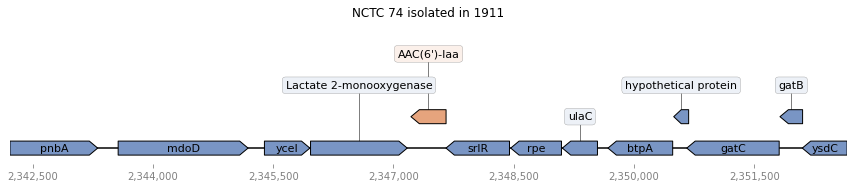

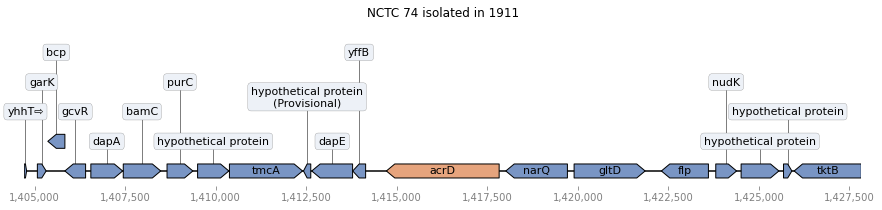

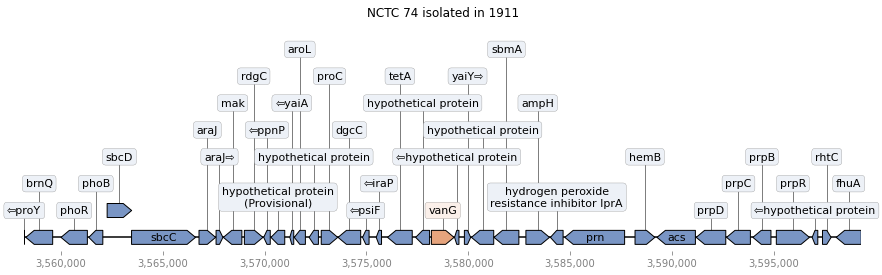

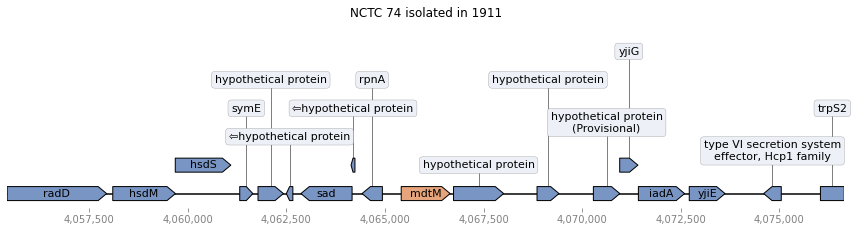

In [11]:
class MyCustomTranslator(BiopythonTranslator):
    def compute_feature_color(self, feature):
        if "gene" in feature.qualifiers:
            if (
                "acrB_1" in feature.qualifiers["gene"][0]
                or "ddlA" in feature.qualifiers["gene"][0]
                or "mdtM" in feature.qualifiers["gene"][0]
            ):
                return "#E6A47D"
        if "product" in feature.qualifiers:
            if "Aminoglycoside" in feature.qualifiers["product"][0]:
                return "#E6A47D"
        if feature.type == "CDS":
            return "#7995C4"
        elif feature.type == "repeat_region":
            return sns.color_palette("deep")[1]
        elif feature.type == "mobile_element":
            return sns.color_palette("deep")[3]
        else:
            return sns.color_palette("deep")[2]

    def compute_feature_label(self, feature):
        if feature.type == "restriction_site":
            return None
        if "gene" in feature.qualifiers:
            if "acrB_1" in feature.qualifiers["gene"][0]:
                return "acrD"
            if "ddlA" in feature.qualifiers["gene"][0]:
                return "vanG"
            if "_" in feature.qualifiers["gene"][0]:
                return feature.qualifiers["gene"][0].split("_")[0]
        else:
            prodName = feature.qualifiers["product"][0]
            # print(prodName)
            if "Aminoglycoside" in feature.qualifiers["product"][0]:
                return "AAC(6')-Iaa"
            if "thylakoid" in feature.qualifiers["product"][0]:
                return "btpA"
            if "VI_effect_Hcp1:" in feature.qualifiers["product"][0]:
                return "type VI secretion system effector, Hcp1 family"
            if "NCBIFAM" in prodName or "NCBI Protein Cluster" in prodName:
                # print(prodName)
                try:
                    NewprodName = prodName.split(": ")[1]
                    return NewprodName
                except:
                    return prodName
            # print(feature.qualifiers)
        return BiopythonTranslator.compute_feature_label(self, feature)

    def compute_filtered_features(self, features):
        null_list = ["source", "gene"]
        passing = []
        for feature in features:
            if feature.type in null_list:
                continue
            else:
                passing.append(feature)
        return passing


record_dict = SeqIO.to_dict(
    SeqIO.parse(
        "/home/ak586/baym/projects/project_microtrawler/data/2_analyze-seqs/NCTC/ena/NCTC74/assembly/assembly_prokka/assembly_prokka.gbk",
        "genbank",
    )
)
print(record_dict)
record = record_dict["UFRA01000001.1"]
graphic_record = MyCustomTranslator().translate_record(record)

cgraphic_record = graphic_record.crop((2347219 - 5000, 2347656 + 5000))
ax, _ = cgraphic_record.plot(
    figure_width=15, with_ruler=True, strand_in_label_threshold=7
)
plt.title("NCTC 74 isolated in 1911")
ax.figure.savefig("NCTC74-AAC-neigh.png", bbox_inches="tight", dpi=200)

# 1414715
cgraphic_record = graphic_record.crop((1414715 - 10000, 1417828 + 10000))
ax, _ = cgraphic_record.plot(
    figure_width=15, with_ruler=True, strand_in_label_threshold=7
)
plt.title("NCTC 74 isolated in 1911")
ax.figure.savefig("NCTC74-acrD-neigh.png", bbox_inches="tight", dpi=200)


# 3578193
cgraphic_record = graphic_record.crop((3578193 - 20000, 3579305 + 20000))
ax, _ = cgraphic_record.plot(
    figure_width=15, with_ruler=True, strand_in_label_threshold=7
)
plt.title("NCTC 74 isolated in 1911")
ax.figure.savefig("NCTC74-vanG-neigh.png", bbox_inches="tight", dpi=200)

4065413
cgraphic_record = graphic_record.crop((4065413 - 10000, 4066654 + 10000))
ax, _ = cgraphic_record.plot(
    figure_width=15, with_ruler=True, strand_in_label_threshold=7
)
plt.title("NCTC 74 isolated in 1911")
ax.figure.savefig("NCTC74-mdtM-neigh.png", bbox_inches="tight", dpi=200)

{'UGQG01000001.1': SeqRecord(seq=Seq('CTTTGTTGCCAGCGCGTGATGGCGGGAACTCAAAGGAGACTGCCGGTGATAAAC...TGA'), id='UGQG01000001.1', name='UGQG01000001.1', description='Genus species strain strain', dbxrefs=[]), 'UGQG01000002.1': SeqRecord(seq=Seq('CTTAGGACCGTTATAGTTACGCCGCCGTTTACCGGGGCTTCGATCAGAAGCTTC...ACC'), id='UGQG01000002.1', name='UGQG01000002.1', description='Genus species strain strain', dbxrefs=[]), 'UGQG01000003.1': SeqRecord(seq=Seq('GGGTGCGAAAGCGCCCTTTTTTGTGCATAATGCACAGGAAATCAGCGATACCTT...TTC'), id='UGQG01000003.1', name='UGQG01000003.1', description='Genus species strain strain', dbxrefs=[]), 'UGQG01000004.1': SeqRecord(seq=Seq('CCCGAAGGGTGCTCCCACTGCTTGTACGTACACGGTTTCAGGTTCTTTTTCACT...TTA'), id='UGQG01000004.1', name='UGQG01000004.1', description='Genus species strain strain', dbxrefs=[]), 'UGQG01000005.1': SeqRecord(seq=Seq('GTATAGACCCGAAACCCGGTGATCTAGCCATGGGCAGGTTGAAGGTTGGGTAAC...CGC'), id='UGQG01000005.1', name='UGQG01000005.1', description='Genus species strain strain', dbxrefs

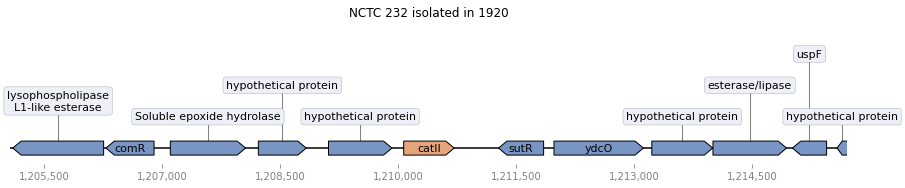

In [12]:
class MyCustomTranslator(BiopythonTranslator):
    def compute_feature_color(self, feature):
        if "gene" in feature.qualifiers:
            if "cmlA" in feature.qualifiers["gene"][0]:
                return "#E6A47D"
        if feature.type == "CDS":
            return "#7995C4"
        elif feature.type == "repeat_region":
            return sns.color_palette("deep")[1]
        elif feature.type == "mobile_element":
            return sns.color_palette("deep")[3]
        else:
            return sns.color_palette("deep")[2]

    def compute_feature_label(self, feature):
        if feature.type == "restriction_site":
            return None
        if "gene" in feature.qualifiers:
            if "cmlA" in feature.qualifiers["gene"][0]:
                return "catII"
            if "_" in feature.qualifiers["gene"][0]:
                return feature.qualifiers["gene"][0].split("_")[0]
        else:
            prodName = feature.qualifiers["product"][0]
            # print(prodName)
            if "cmlA" in feature.qualifiers["product"][0]:
                return "catII"
            if "thylakoid" in feature.qualifiers["product"][0]:
                return "btpA"
            if "NCBIFAM" in prodName or "NCBI Protein Cluster" in prodName:
                # print(prodName)
                try:
                    NewprodName = prodName.split(": ")[1]
                    return NewprodName
                except:
                    return prodName
            # print(feature.qualifiers)
        return BiopythonTranslator.compute_feature_label(self, feature)

    def compute_filtered_features(self, features):
        null_list = ["source", "gene"]
        passing = []
        for feature in features:
            if feature.type in null_list:
                continue
            else:
                passing.append(feature)
        return passing


record_dict = SeqIO.to_dict(
    SeqIO.parse(
        "/home/ak586/baym/projects/project_microtrawler/data/2_analyze-seqs/NCTC/ena/NCTC232/assembly/assembly_prokka/assembly_prokka.gbk",
        "genbank",
    )
)
print(record_dict)
record = record_dict["UGQG01000001.1"]
# 1410370..1411185
# 299166.0 	300149.0
graphic_record = MyCustomTranslator().translate_record(record)
cgraphic_record = graphic_record.crop((1210069 - 5000, 1210710 + 5000))
ax, _ = cgraphic_record.plot(
    figure_width=15, with_ruler=True, strand_in_label_threshold=7
)
plt.title("NCTC 232 isolated in 1920")
ax.figure.savefig("NCTC232-catII-neigh.png", bbox_inches="tight", dpi=200)

In [13]:
df

,Accession_Number,Strain,Assembly_No,Year_Cultured,ORF_ID,Contig,Start,Stop,Orientation,Cut_Off,...,Predicted_DNA,Predicted_Protein,CARD_Protein_Sequence,Percentage Length of Reference Sequence,ID,Model_ID,Nudged,Note,Species,Subspecies
0,NCTC1,Shigella flexneri,1,1914,ENA|LM651928|LM651928.1_231 # 254564 # 255658 ...,ENA|LM651928|LM651928.1_231,254564.0,255658.0,+,Strict,...,ATGGAAAAACTGCGGGTAGGAATCGTTTTTGGTGGTAAATCAGCGG...,MEKLRVGIVFGGKSAEHEVSLQSAKNIVDAIDKSRFDVVLLGIDKQ...,MQNKKIAVIFGGNSTEYEVSLQSASAVFENINTNKFDIIPIGITRS...,104.3,gnl|BL_ORD_ID|1071|hsp_num:0,1157.0,Null,Null,Shigella flexneri,Null
1,NCTC1,Shigella flexneri,1,1914,ENA|LM651928|LM651928.1_406 # 416835 # 419984 ...,ENA|LM651928|LM651928.1_406,416835.0,419984.0,-,Strict,...,ATGCCTAATTTCTTTATCGATCGCCCGATTTTTGCGTGGGTGATCG...,MPNFFIDRPIFAWVIAIIIMLAGGLAILKLPVAQYPTIAPPAVTIS...,MPNFFIDRPIFAWVIAIIIMLAGGLAILKLPVAQYPTIAPPAVTIS...,100.0,gnl|BL_ORD_ID|1013|hsp_num:0,1104.0,Null,Null,Shigella flexneri,Null
2,NCTC1,Shigella flexneri,1,1914,ENA|LM651928|LM651928.1_407 # 420007 # 421200 ...,ENA|LM651928|LM651928.1_407,420007.0,421200.0,-,Strict,...,ATGAACAAAAACAGAGGGTTTACGCCTCTGGCGGTCGTTCTGATGC...,MNKNRGFTPLAVVLMLSGSLALTGCDDKQAQQGGQQMPAVGVVTVK...,MNKNRGFTPLAVVLMLSGSLALTGCDDKQAQQGGQQMPAVGVVTVK...,100.0,gnl|BL_ORD_ID|2328|hsp_num:0,2661.0,Null,Null,Shigella flexneri,Null
3,NCTC1,Shigella flexneri,1,1914,ENA|LM651928|LM651928.1_913 # 909925 # 911673 ...,ENA|LM651928|LM651928.1_913,909925.0,911673.0,+,Strict,...,ATGCATAACGACAAAGATCTCTCTACGTGGCAGACATTCCGCCGAC...,MHNDKDLSTWQTFRRLWPTIAPFKAGLIVAGVALILNAASDTFMLS...,MHNDKDLSTWQTFRRLWPTIAPFKAGLIVAGVALILNAASDTFMLS...,100.0,gnl|BL_ORD_ID|2192|hsp_num:0,2423.0,Null,Null,Shigella flexneri,Null
4,NCTC1,Shigella flexneri,1,1914,ENA|LM651928|LM651928.1_1084 # 1070322 # 10715...,ENA|LM651928|LM651928.1_1084,1070322.0,1071530.0,-,Strict,...,ATGTCCCGCGTATCGCAGGCGAGGAACCTGGGTAAATATTTCCTGC...,MSRVSQARNLGKYFLLIDNMLVVLGFFVVFPLISIRFVDQMGWAAV...,MSRVSQARNLGKYFLLIDNMLVVLGFFVVFPLISIRFVDQMGWAAV...,100.0,gnl|BL_ORD_ID|342|hsp_num:0,375.0,Null,Null,Shigella flexneri,Null
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31498,NCTC14382,Yersinia canariae,1,2018,ENA|CP043727|CP043727.1_3533 # 3911579 # 39121...,ENA|CP043727|CP043727.1_3533,3911579.0,3912193.0,+,Strict,...,ATGAAAGCAATAATTATTGATGACCATCCTCTTGCGATCGCCGCTA...,MKAIIIDDHPLAIAAIRNLLTKNDIEILAELVEGGSAVQRIETLKP...,MNAIIIDDHPLAIAAIRNLLIKNDIEILAELTEGGSAVQRVETLKP...,100.0,gnl|BL_ORD_ID|938|hsp_num:0,1015.0,Null,Null,Yersinia canariae,Null
31499,NCTC14382,Yersinia canariae,1,2018,ENA|CP043727|CP043727.1_3965 # 4393476 # 43941...,ENA|CP043727|CP043727.1_3965,4393476.0,4394108.0,+,Strict,...,ATGGTTCTCGGCAAGCCACAAACAGACCCGACTCTCGAATGGTTCC...,MVLGKPQTDPTLEWFLSHCHIHKYPSKSTLIHQGEKAETLYYIVKG...,MVLGKPQTDPTLEWFLSHCHIHKYPSKSKLIHQGEKAETLYYIVKG...,100.0,gnl|BL_ORD_ID|803|hsp_num:0,869.0,Null,Null,Yersinia canariae,Null
31500,NCTC14382,Yersinia canariae,1,2018,ENA|CP043727|CP043727.1_734 # 828203 # 829966 ...,ENA|CP043727|CP043727.1_734,828203.0,829966.0,+,Strict,...,ATGAAAGCAGCGCGCCCCGGGAAGTTAAAGCGCCAGGAAGAACAAG...,MKAARPGKLKRQEEQASFISWRFALLCGCILLALVGLMLRTAYLQV...,MVKFNSSRKSGKSKKTIRKLTAPETVKQNKPQKVFEKCFMRGRYML...,96.23,gnl|BL_ORD_ID|2503|hsp_num:0,2886.0,Null,Null,Yersinia canariae,Null
31501,NCTC14382,Yersinia canariae,1,2018,ENA|CP043727|CP043727.1_3889 # 4333449 # 43346...,ENA|CP043727|CP043727.1_3889,4333449.0,4334633.0,-,Strict,...,ATGTCTAAAGAAAAGTTTGAACGTACAAAACCGCACGTTAATGTGG...,MSKEKFERTKPHVNVGTIGHVDHGKTTLTAAITTVLAKTYGGSARA...,MLSPEGESTIVRNIAVSKEKFERTKPHVNVGTIGHVDHGKTTLTAA...,96.33,gnl|BL_ORD_ID|1972|hsp_num:0,2158.0,Null,Null,Yersinia canariae,Null


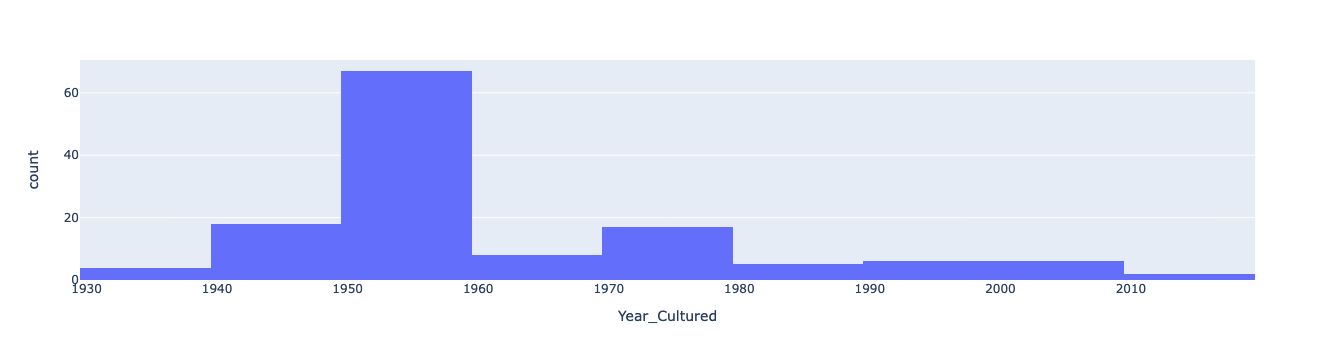

In [14]:
px.histogram(
    df.loc[df["Accession_Number"].isin(ecoli_mlplasmid_out["AccNum"])].drop_duplicates(
        subset=["Accession_Number"]
    ),
    x="Year_Cultured",
)

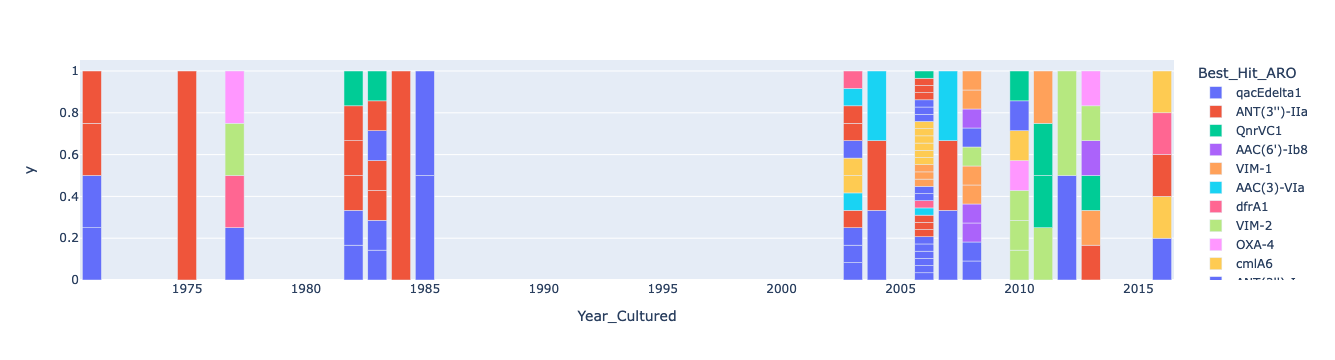

In [15]:
px.bar(
    rgiintegron,
    x="Year_Cultured",
    y=rgiintegron["Year_Cultured"].map(
        (1 / rgiintegron["Year_Cultured"].value_counts()).to_dict()
    ),
    hover_data=[
        "Accession_Number",
        "Resistance Mechanism",
        "Best_Hit_ARO",
        "Drug Class",
        "AMR Gene Family",
        "Strain",
    ],
    color="Best_Hit_ARO",
)

In [16]:
sul_resist["Strain"].value_counts()

Escherichia coli                                       25
Pseudomonas aeruginosa                                 17
Klebsiella pneumoniae                                  11
Acinetobacter baumannii                                 7
Enterobacter cloacae                                    3
Actinobacillus rossii                                   2
Oligella ureolytica                                     2
Achromobacter xylosoxidans subsp. xylosoxidans          2
Citrobacter koseri                                      2
Klebsiella pneumoniae sensu stricto                     2
Salmonella enterica subsp. houtenae serotype Houten     1
Providencia rettgeri                                    1
Proteus vulgaris                                        1
acinetobacter genospecies 13                            1
Proteus mirabilis                                       1
Shigella boydii                                         1
Oligella urethralis                                     1
Shewanella put

In [ ]:
df.drop_duplicates(subset=["Accession_Number"])["Strain"].value_counts()[
    "Klebsiella pneumoniae"
]

In [ ]:
rgiintegron